In [374]:
import ticktack
import pandas
from jax.numpy import arange, sin, pi, array, mean, greater, less, equal, where
from scipy.optimize import minimize
import matplotlib.pyplot as plt

The basic question is what is the probability of detecting consecutive events based on the distribution of the data. The first step then will be to determine the distribution of the data. This will be done be resampling the points after the event has been removed.

In [385]:
def sine(t, p):
    """
    Generates a simple sinusoidal production function. p is an array containing the amplitude of the production sinusoid and the phase of the sinusoid.
    """
    return 1.88 + p[0] * 1.88 * sin(2 * pi / 11 * t + p[1])

def rect(t, p):
    """
    Generates a rectangular miyake event. p is an array that contains the start and end times as well as the height of the production function 
    """
    condition = equal(greater(t, p[0]), less(t, p[1]))
    return where(condition, p[3], 0.0)

def prod(t, *args):
    amplitude, phase, start, end, height = array(list(args))
    sine_params = array([amplitude, phase])
    rect_params = array([start, end, height])
    return sine(t, sine_params) + rect(t, rect_params)

In [389]:
prod(774., params)

ValueError: not enough values to unpack (expected 5, got 1)

In [386]:
annual_samples = 48                  # 4 samples per month
sample_times = arange(-360.0, 790.0)  # Times at which to collect samples
growth_bools = array([0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0])
params = [1.0, 1.25, 774, 775, 20.0]

In [388]:
cbm = ticktack.load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()
model, steady_state = cbm.run(sample_times, annual_samples, 
    production=prod, steady_state_production=1.88, args=params)

ValueError: Non-hashable static arguments are not supported. An error occured during a call to 'run' while trying to hash an object of type <class 'jaxlib.xla_extension.DeviceArray'>, [  1.     1.25 774.   775.    20.  ]. The error was:
TypeError: unhashable type: 'DeviceArray'


In [378]:
troposphere = cbm.bin_data( # Bins the data into annual values
    model[:, 2],   # Selecting only the years that I have data for 
    annual_samples,                         # Number of samples per year 
    sample_times,                           # Times to return the binned values for 
    growth_bools                            # Boolean mask of growth seasons
)

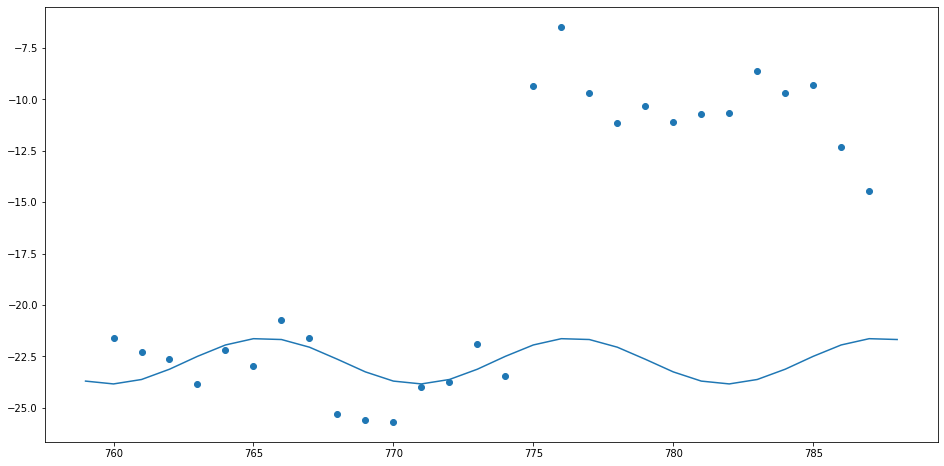

In [379]:
miyake = pandas.read_csv("Miyake12.csv", sep=" ")

troposphere = 1000 * (troposphere - steady_state[2]) / steady_state[2]
troposphere = troposphere + mean(array([*miyake["d14c"][0:4]]))

plt.figure("Model")
plt.plot(sample_times[-31:-1], troposphere[-31:-1])
plt.scatter(miyake["year"], miyake["d14c"])

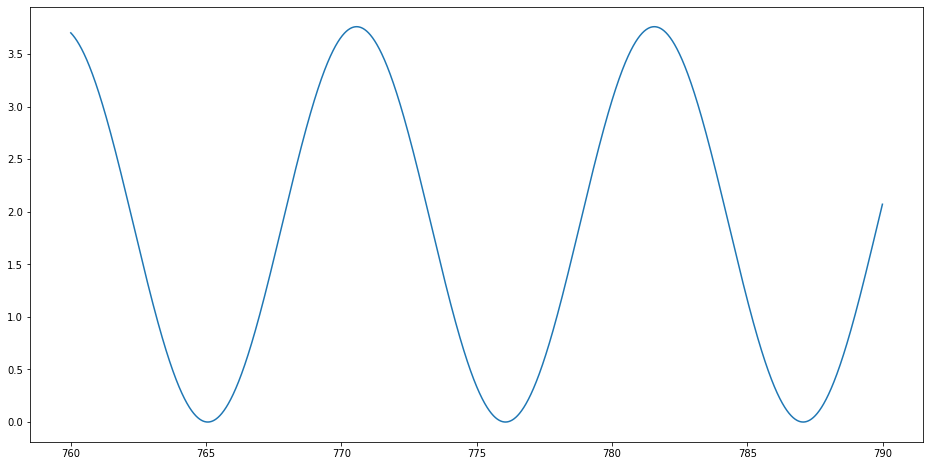

In [380]:
times = arange(760.0, 790.0, 0.01)
production = prod(times)

plt.plot(times, production)